In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree 

# Data preprocessing

現有的數據，某些欄位存在著字串（如：area, kind），sklearn的算法中只允許數據以數值類型被輸入，以下將針對這些字串進行編碼處理，讓其能被輸入sklearn中建立樹模型。編碼的方法有很多種，以下將根據各個編碼方式的特性與我自身對於該特徵的理解選擇我認為較合適的編碼方法。

In [2]:
tc = pd.read_csv("./updated_tc_Regression.csv")
tc.info()
tc.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4841 entries, 0 to 4840
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kind           4841 non-null   object 
 1   area           4841 non-null   object 
 2   space          4841 non-null   float64
 3   floor          4841 non-null   int64  
 4   cat_floor      4841 non-null   object 
 5   top_floor      4841 non-null   int64  
 6   cat_top_floor  4841 non-null   object 
 7   mrt            4841 non-null   int64  
 8   bd             4841 non-null   int64  
 9   pet            4841 non-null   int64  
 10  elevator       4841 non-null   int64  
 11  parking        4841 non-null   int64  
 12  balcony        4841 non-null   int64  
 13  price          4841 non-null   int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 529.6+ KB


kind area  space  floor cat_floor  top_floor cat_top_floor  mrt  bd  pet  \
0  整層住家  北屯區   28.0      2     1~5 樓         15       11~15 樓    0   1    0   
1  獨立套房  北屯區   12.6      6    6~10 樓          7        6~10 樓    0   1    0   
2  獨立套房  北屯區   13.0      6    6~10 樓          7        6~10 樓    0   1    0   
3  獨立套房  北屯區   13.0      2     1~5 樓          7        6~10 樓    0   1    0   
4  獨立套房   北區   13.0     12   11~15 樓         12       11~15 樓    0   0    0   

   elevator  parking  balcony  price  
0         1        0        0  29000  
1         1        0        0   8699  
2         1        0        0  11000  
3         1        0        0  11000  
4         1        0        0  11000

In [3]:
tc.dtypes

kind              object
area              object
space            float64
floor              int64
cat_floor         object
top_floor          int64
cat_top_floor     object
mrt                int64
bd                 int64
pet                int64
elevator           int64
parking            int64
balcony            int64
price              int64
dtype: object

## Frequency encoding

area欄位，代表著數據的所在行政區，考量到地區的可能取值有19個行政區，我們的目標是希望能找到一種encoding的方式能替代行政區，且數值間的大小關係也能充份的保留住原本區域與區域之間的關係；若將其以最一般的one-hot encoding會使特徵增加18個特徵，可能會導致模型太複雜、解釋性較差，再加上某些行政區本身樣本數就少，對於模型的影響力也會很低，形成無用的特徵；若將其以target encoding把行政區的取值設置為各行政區的平均租金似乎也不太合理，還需要考量到租屋類型與坪數這些明顯更重要的特徵，例如：在某些行政區的套房樣本數很少，整層住家的樣本數卻很多，此時該行政區的平均租金必然會很高，這很有可能讓模型發生嚴重的偏差，應避免讓行政區和租金的關係太過於緊密避免發生估計偏差；在此，採用frequency encoding是比較佳的方式，透過各行政區所佔總樣本的頻率之比例來編碼做為各行政區的取值，此作法如同把行政區轉為台中市租屋市場中各行政區的租屋供給（其實也是需求），我想能非常好的替代原本的字串，此做法下兩個數值間的關係是有意義的，代表著兩地區的租屋供給的差距。

In [4]:
tc.area

0       北屯區
1       北屯區
2       北屯區
3       北屯區
4        北區
       ... 
4836     北區
4837    北屯區
4838     西區
4839     北區
4840    西屯區
Name: area, Length: 4841, dtype: object

In [5]:
area_freq = tc.area.value_counts(normalize = True).to_dict()
area_freq

{'西屯區': 0.2171039041520347,
 '北屯區': 0.1658748192522206,
 '北區': 0.15595951249741788,
 '西區': 0.0712662673001446,
 '南屯區': 0.06630861392274323,
 '南區': 0.05618673827721545,
 '東區': 0.03945465812848585,
 '太平區': 0.03656269365833505,
 '烏日區': 0.02995248915513324,
 '龍井區': 0.028713075810782897,
 '大里區': 0.027473662466432555,
 '豐原區': 0.019004337946705228,
 '沙鹿區': 0.017971493493079943,
 '中區': 0.01693864903945466,
 '大雅區': 0.015286097913654203,
 '潭子區': 0.011567857880603181,
 '清水區': 0.009915306754802726,
 '霧峰區': 0.007229911175376988,
 '后里區': 0.007229911175376988}

In [6]:
tc['area_freq'] = tc.area.map(area_freq)
tc.head(8)

kind area  space  floor cat_floor  top_floor cat_top_floor  mrt  bd  pet  \
0  整層住家  北屯區   28.0      2     1~5 樓         15       11~15 樓    0   1    0   
1  獨立套房  北屯區   12.6      6    6~10 樓          7        6~10 樓    0   1    0   
2  獨立套房  北屯區   13.0      6    6~10 樓          7        6~10 樓    0   1    0   
3  獨立套房  北屯區   13.0      2     1~5 樓          7        6~10 樓    0   1    0   
4  獨立套房   北區   13.0     12   11~15 樓         12       11~15 樓    0   0    0   
5  獨立套房  西屯區    7.3      6    6~10 樓          6        6~10 樓    1   0    0   
6  獨立套房  西屯區   13.3      3     1~5 樓          5         1~5 樓    0   1    0   
7  獨立套房  霧峰區   18.7      3     1~5 樓          5         1~5 樓    0   1    0   

   elevator  parking  balcony  price  area_freq  
0         1        0        0  29000   0.165875  
1         1        0        0   8699   0.165875  
2         1        0        0  11000   0.165875  
3         1        0        0  11000   0.165875  
4         1        0        0  11000   0.155960  
5         1        0        0   7300   0.217104  
6         1        0        0   8999   0.217104  
7         1        0        0   8998   0.007230

## One-hot encoding

租屋類型kind欄位就非常的適合one hot encoding，由於其取值只有三個且取值間對租金的影響力很大，再加上one hot encoding後僅僅增加了2個特徵，編碼後能完整的替代原本的特徵。

In [7]:
on_hot_encode_kind = pd.get_dummies(tc['kind'], prefix='kind')
on_hot_encode_kind

kind_分租套房  kind_整層住家  kind_獨立套房
0             0          1          0
1             0          0          1
2             0          0          1
3             0          0          1
4             0          0          1
...         ...        ...        ...
4836          0          0          1
4837          0          1          0
4838          0          0          1
4839          0          0          1
4840          0          0          1

[4841 rows x 3 columns]

In [8]:
tc = pd.concat([tc, on_hot_encode_kind], axis = 1)

tc_reset_colums= ['kind'
               , 'kind_分租套房'
               , 'kind_整層住家'
               , 'kind_獨立套房' 
               , 'area'
               , 'area_freq'
               , 'space'
               , 'floor'
               ,'cat_floor'
               , 'top_floor'
               , 'cat_top_floor'
               , 'mrt'
               , 'bd'
               , 'pet'
               , 'elevator'
               , 'parking'
               , 'balcony'
               , 'price'
               ]

tc = tc[tc_reset_colums]
tc.rename(columns={'kind_分租套房': 'kind_sublet'
                   , 'kind_整層住家': 'kind_whole_floor'
                   , 'kind_獨立套房':'kind_independent'}
          , inplace=True)

## Create X and y

<center>變數說明</center>


y：  
-price：房租租金  

X：  
-kind_sublet：租屋類型為分租套房  
-kind_whole_floor：租屋類型為整層住家  
-kind_independent：租屋類型為獨立套房  
-area_freq：所在行政區之頻率比例，可以根據[5]還原  
-space：租屋坪數  
-floor：租屋所在樓層  
-mrt：是否近捷運，1=是，0=否   
-bd：是否近商圈，1=是，0=否  
-pet：是否能養寵物，1=是，0=否  
-elevator：是否有電梯，1=是，0=否  
-parking：是否有附停車位，1=是，0=否  
-balcony：是否有陽台，1=是，0=否  



In [9]:
tc.iloc[[1744],:]

kind  kind_sublet  kind_whole_floor  kind_independent area  area_freq  \
1744  整層住家            0                 1                 0  北屯區   0.165875   

      space  floor cat_floor  top_floor cat_top_floor  mrt  bd  pet  elevator  \
1744   28.0     12   11~15 樓         14       11~15 樓    0   1    0         1   

      parking  balcony  price  
1744        0        0  22999

In [10]:
X = tc.drop(['cat_floor','cat_top_floor', 'price', 'kind', 'area', 'top_floor'], axis = 1)
y = tc['price']
X.columns

Index(['kind_sublet', 'kind_whole_floor', 'kind_independent', 'area_freq',
       'space', 'floor', 'mrt', 'bd', 'pet', 'elevator', 'parking', 'balcony'],
      dtype='object')

# Decision Tree Regression

本專案之迴歸方式採用樹模型，首先將全部的資料分為80%訓練集，20%測試集。

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

## Bulid decision tree (split with MSE)

我們先嘗試將CART樹在不調整任何參數的情況下讓樹盡可能的生成並以MSE來分枝。

In [13]:
dtr = DecisionTreeRegressor(random_state = 100
                            , criterion = 'squared_error'
                           ).fit(X_train, y_train)

real_y_test = y_test.to_numpy()
pred_y_test = dtr.predict(X_test)

# print(real_y_test)
# print(pred_y_test)

print('training R squared :', dtr.score(X_test, y_test))
print('testing R squared :', dtr.score(X_train, y_train))


training R squared : 0.6658057439807048
testing R squared : 0.9141571860358944


In [14]:
importance = list(zip(dtr.feature_importances_, X.columns))
sorted(importance)

[(0.00013473719515322069, 'kind_sublet'),
 (0.0002573621104879609, 'kind_independent'),
 (0.000844926717956021, 'balcony'),
 (0.006506387794949951, 'pet'),
 (0.007603271254435929, 'bd'),
 (0.010295930528897976, 'parking'),
 (0.013833857722196584, 'elevator'),
 (0.014211588577109312, 'mrt'),
 (0.064081740011026, 'floor'),
 (0.07670423876319077, 'area_freq'),
 (0.3756641982119519, 'space'),
 (0.4298617611126443, 'kind_whole_floor')]

根據上方training set 與test set 的$R^2$結果，很明顯模型是overfitting了，不過我們也透過了本次建模了解到各個特徵的重要性，最重要的兩個特徵為'是否為整層住家'以及'坪數'，非常的合理，而'是否有陽台'、'是否為獨立套房'以及'是否為分租套房'是最不重要的，可見台中市的租屋類型以租金來分的話呈現二分化，整層住家為一類，其他類型為一類。

In [15]:
# text_representation = tree.export_text(dtr, feature_names = X.columns.tolist())
# print(text_representation)

## Decision tree pruning with CCP (split with MSE)

將上小節訓練集數據以MSE劃分的完整的樹模型以CCP的方式剪枝，首先蒐集到每個剪枝階段下所對應到的複雜度懲罰項alpha，與每個alpha下所對應的那棵樹的MSE（impurities），關於CCP的詳細在此不多做介紹。

In [16]:
from sklearn.model_selection import cross_val_score
import time 

In [17]:
dtr = DecisionTreeRegressor(random_state = 100
                            , criterion = 'squared_error'
                           ).fit(X_train, y_train)


model_prune = dtr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = model_prune['ccp_alphas']
impurities = model_prune['impurities']

pd.DataFrame(model_prune).T

0             1             2             3     \
ccp_alphas  0.000000e+00  0.000000e+00  0.000000e+00  3.865352e-12   
impurities  1.641337e+07  1.641337e+07  1.641337e+07  1.641337e+07   

                    4             5             6             7     \
ccp_alphas  1.455192e-11  1.546141e-11  1.291326e-05  4.304397e-05   
impurities  1.641337e+07  1.641337e+07  1.641337e+07  1.641337e+07   

                    8             9     ...          2278          2279  \
ccp_alphas  4.304401e-05  4.304407e-05  ...  1.058121e+06  1.128905e+06   
impurities  1.641337e+07  1.641337e+07  ...  4.883234e+07  5.109015e+07   

                    2280          2281          2282          2283  \
ccp_alphas  1.263963e+06  1.946330e+06  2.606383e+06  4.506460e+06   
impurities  5.235411e+07  5.430044e+07  5.690682e+07  6.141328e+07   

                    2284          2285          2286          2287  
ccp_alphas  4.631589e+06  8.225819e+06  4.179670e+07  7.513520e+07  
impurities  6.604487e+07  7.427069e+07  1.160674e+08  1.912026e+08  

[2 rows x 2288 columns]

In [18]:
len(ccp_alphas)

2288

### CV to choose best ccp_alpha (evaluate with R squared)

我們希望能透過CV的方式找到平均而言最棒的那個alpha，具體做法是將蒐集到的所有alpha分別帶入以'全樣本'建模的5fold CV，並選擇在每次CV的test set下平均$R^2$最高的那個alpha作為最佳alpha。採用全樣本與5CV的原因是為更符合當前test set為全樣本20%的條件，讓每次CV的test set與當前要預測的test set較相近。

In [19]:
ccp_train_r2s = []
ccp_test_r2s = []
start = time.time()

for i in ccp_alphas:
    
    dtr_prune = DecisionTreeRegressor(criterion='squared_error'
                                      , ccp_alpha= i)
    
    ccp_test_r2 = cross_val_score(dtr_prune, X, y, cv=5, scoring="r2", n_jobs = 4).mean()
    
    dtr_prune.fit(X_train,y_train)
    ccp_train_r2 = dtr_prune.score(X_train,y_train)
    
    ccp_train_r2s.append(ccp_train_r2)
    ccp_test_r2s.append(ccp_test_r2)

end = time.time()
print('The calculation cost: ',end - start, 'sec')

The calculation cost:  129.2767939567566 sec


In [20]:
sorted(ccp_test_r2s, reverse = True)[0:10]

[0.6905056190876457,
 0.6897285332599814,
 0.6847330340316574,
 0.6760647112478597,
 0.671569792775968,
 0.671569792775968,
 0.6604354839142912,
 0.660217910659313,
 0.6583461212317532,
 0.6579372697287773]

In [21]:
# aplha = [, ) is the best
top_3_r2 = sorted([* zip(ccp_alphas, ccp_test_r2s, ccp_train_r2s)], key=lambda a: a[1], reverse = True)[0:3]
top_3_r2

[(1263962.6280006208, 0.6905056190876457, 0.7261851493602425),
 (1946330.0617188038, 0.6897285332599814, 0.7160057367534137),
 (2606383.347107075, 0.6847330340316574, 0.7023742093862929)]

[21]的結果為平均而言最棒的3個alpha以及他們所對應到的training set 與test set$R^2$。下方將展示alpha與$R^2$的關係。圖的最左邊表示overfitting，右邊為underfitting。

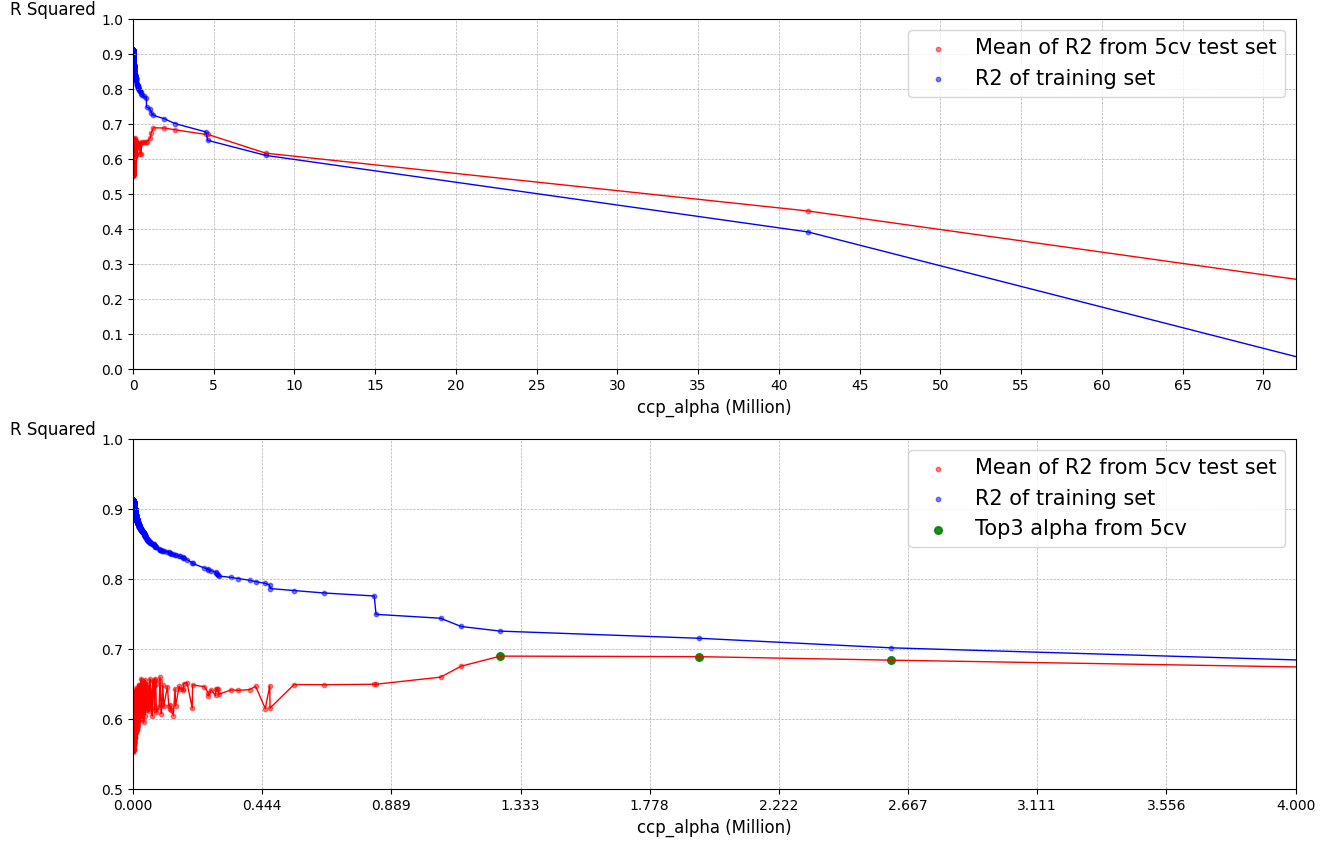

In [22]:
fig = plt.figure(figsize=(15,10))

sub1 = fig.add_subplot(211)
sub1.scatter(ccp_alphas/1000000, ccp_test_r2s, color = 'red', s = 10, alpha = 0.5)  
sub1.scatter(ccp_alphas/1000000, ccp_train_r2s, color = 'blue', s = 10, alpha = 0.5)  
sub1.plot(ccp_alphas/1000000, ccp_test_r2s, color='red', linewidth=1)
sub1.plot(ccp_alphas/1000000, ccp_train_r2s, color='blue', linewidth=1)
sub1.grid(linestyle='--', linewidth=0.5)
sub1.set_xlabel("ccp_alpha (Million)",fontsize=12,rotation=0)
sub1.set_ylabel("R Squared",fontsize=12, rotation=0, loc = 'top')
sub1.set_ylim([0,1])
sub1.set_xlim([0, 72])
sub1.set_xticks(np.linspace(0,70,15))
sub1.set_yticks(np.linspace(0,1,11))
sub1.legend(['Mean of R2 from 5cv test set', 'R2 of training set'], fontsize = 15)


sub2 = fig.add_subplot(212)
sub2.scatter(ccp_alphas/1000000, ccp_test_r2s, color = 'red', s = 10, alpha = 0.5)  
sub2.scatter(ccp_alphas/1000000, ccp_train_r2s, color = 'blue', s = 10, alpha = 0.5)  
for i in top_3_r2:
    sub2.scatter(i[0]/1000000, i[1], color = 'green', s = 30, alpha = 0.9) 
sub2.plot(ccp_alphas/1000000, ccp_test_r2s, color='red', linewidth=1)
sub2.plot(ccp_alphas/1000000, ccp_train_r2s, color='blue', linewidth=1)
sub2.grid(linestyle='--', linewidth=0.5)
sub2.set_xlabel("ccp_alpha (Million)",fontsize=12,rotation=0)
sub2.set_ylabel("R Squared",fontsize=12, rotation=0, loc = 'top')
sub2.set_ylim([0.5,1])
sub2.set_xlim([0, 4])
sub2.set_xticks(np.linspace(0,4,10))
sub2.set_yticks(np.linspace(0.5,1,6))
sub2.legend(['Mean of R2 from 5cv test set', 'R2 of training set', 'Top3 alpha from 5cv'], fontsize = 15)

plt.show()

### Visualize pruned tree on test set

接著我們選擇CV當中的最佳alpah並以training set來建立模型，並且加入了一個每個葉子至少要有五個訓練樣本的條件，因此這邊的training$R^2$與[21]不同，其結果更往test set靠齊，test set $R^2$增加，training set的$R^2$下降。

In [23]:
dtr = DecisionTreeRegressor(random_state = 100
                            , criterion = 'squared_error'
                            , min_samples_leaf = 5
                            , ccp_alpha = top_3_r2[0][0]).fit(X_train, y_train)

pred_y_train = dtr.predict(X_train)
pred_y_test = dtr.predict(X_test)
from sklearn.metrics import mean_absolute_error
print('training set MAE :',mean_absolute_error(y_true = y_train, y_pred = pred_y_train))
print('test set MAE :', mean_absolute_error(y_true = y_test, y_pred = pred_y_test))
print('training R squared :', dtr.score(X_train, y_train))
print('test R squared :', dtr.score(X_test, y_test))

training set MAE : 3541.1085988204945
test set MAE : 3904.503231491259
training R squared : 0.7092267108225283
test R squared : 0.7184548477363382


In [24]:
np.unique(pred_y_test)

array([  7733.96842105,  10819.16602317,  21231.93162393,  27314.22817955,
        36173.1       ,  56083.16666667,  69166.44444444, 121250.        ])

In [25]:
np.unique(pred_y_train)

array([  7733.96842105,  10819.16602317,  21231.93162393,  27314.22817955,
        36173.1       ,  56083.16666667,  69166.44444444, 121250.        ])

[24]與[25]為當前樹模型的預測數值，總共有8個，觀察可以發現在15000以下的預測值只有2個，表示模型更注重於預測高月租的房屋，其背後的原因是在以MSE當作分枝依據時，由於MSE分子的'平方差'特性，在同樣剪掉一個分枝的狀況下，由於高月租的租屋市場價差較高，模型為了讓MSE更小，更傾向剪去價差較小的低單價租屋市場的分支，也就是犧牲低價格租屋市場的解釋力來換取高租屋市場的解釋力。下方將繪製test set預測結果來方便觀察。

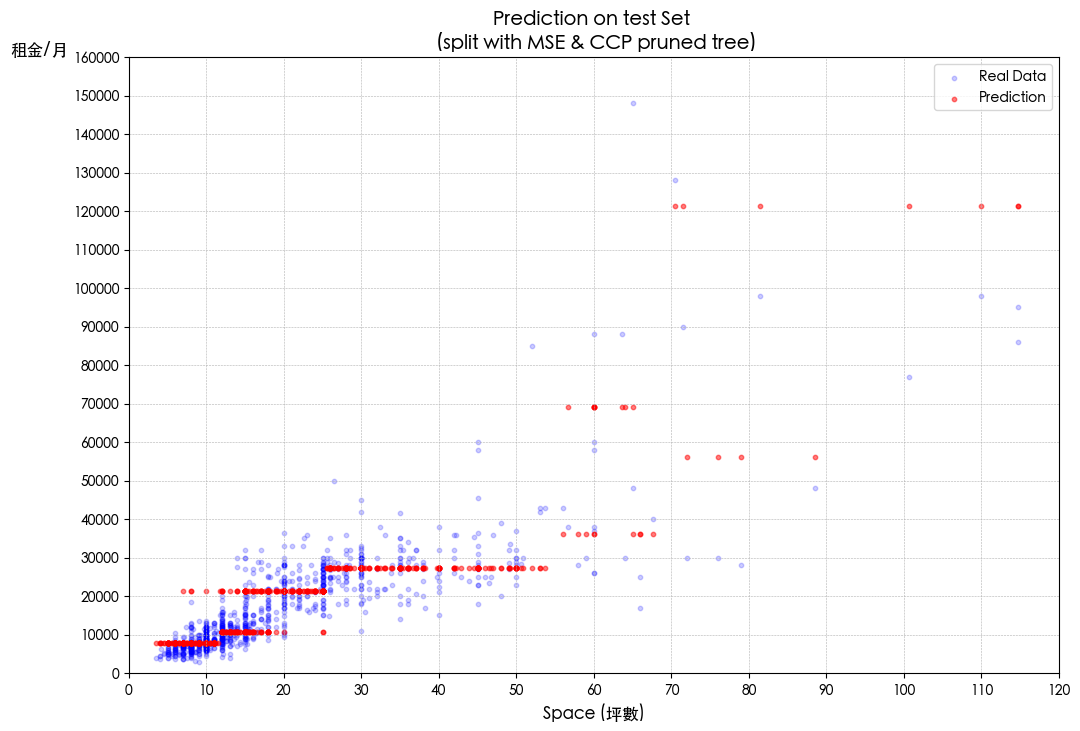

In [26]:
# test set (space and price)

plt.rcParams['font.family'] = ['Heiti TC']

fig2 = plt.figure(figsize=(12,8))

ax = fig2.add_subplot(111)
ax.scatter(X_test['space'], y_test, color = 'blue', s = 10, alpha = 0.2)  
ax.scatter(X_test['space'], pred_y_test, color = 'red', s = 10, alpha = 0.5)  

ax.set_ylim([0,160000])
ax.set_xlim([0, 120])
ax.set_yticks(np.linspace(0,160000,17))
ax.set_xticks(np.linspace(0,120,13))
ax.grid(linestyle='--', linewidth=0.4)

ax.set_xlabel("Space (坪數)",fontsize=12,rotation=0)
ax.set_ylabel("租金/月",fontsize=12, rotation=0, loc = 'top')
ax.set_title('Prediction on test Set \n (split with MSE & CCP pruned tree)', fontsize=14)
ax.legend(['Real Data','Prediction'], fontsize = 10)

plt.show()

In [27]:
text_representation = tree.export_text(dtr, feature_names = X.columns.tolist())
print(text_representation)

|--- kind_whole_floor <= 0.50
|   |--- space <= 11.95
|   |   |--- value: [7733.97]
|   |--- space >  11.95
|   |   |--- value: [10819.17]
|--- kind_whole_floor >  0.50
|   |--- space <= 70.15
|   |   |--- space <= 25.05
|   |   |   |--- value: [21231.93]
|   |   |--- space >  25.05
|   |   |   |--- space <= 55.30
|   |   |   |   |--- value: [27314.23]
|   |   |   |--- space >  55.30
|   |   |   |   |--- floor <= 11.50
|   |   |   |   |   |--- value: [36173.10]
|   |   |   |   |--- floor >  11.50
|   |   |   |   |   |--- value: [69166.44]
|   |--- space >  70.15
|   |   |--- area_freq <= 0.19
|   |   |   |--- value: [56083.17]
|   |   |--- area_freq >  0.19
|   |   |   |--- value: [121250.00]



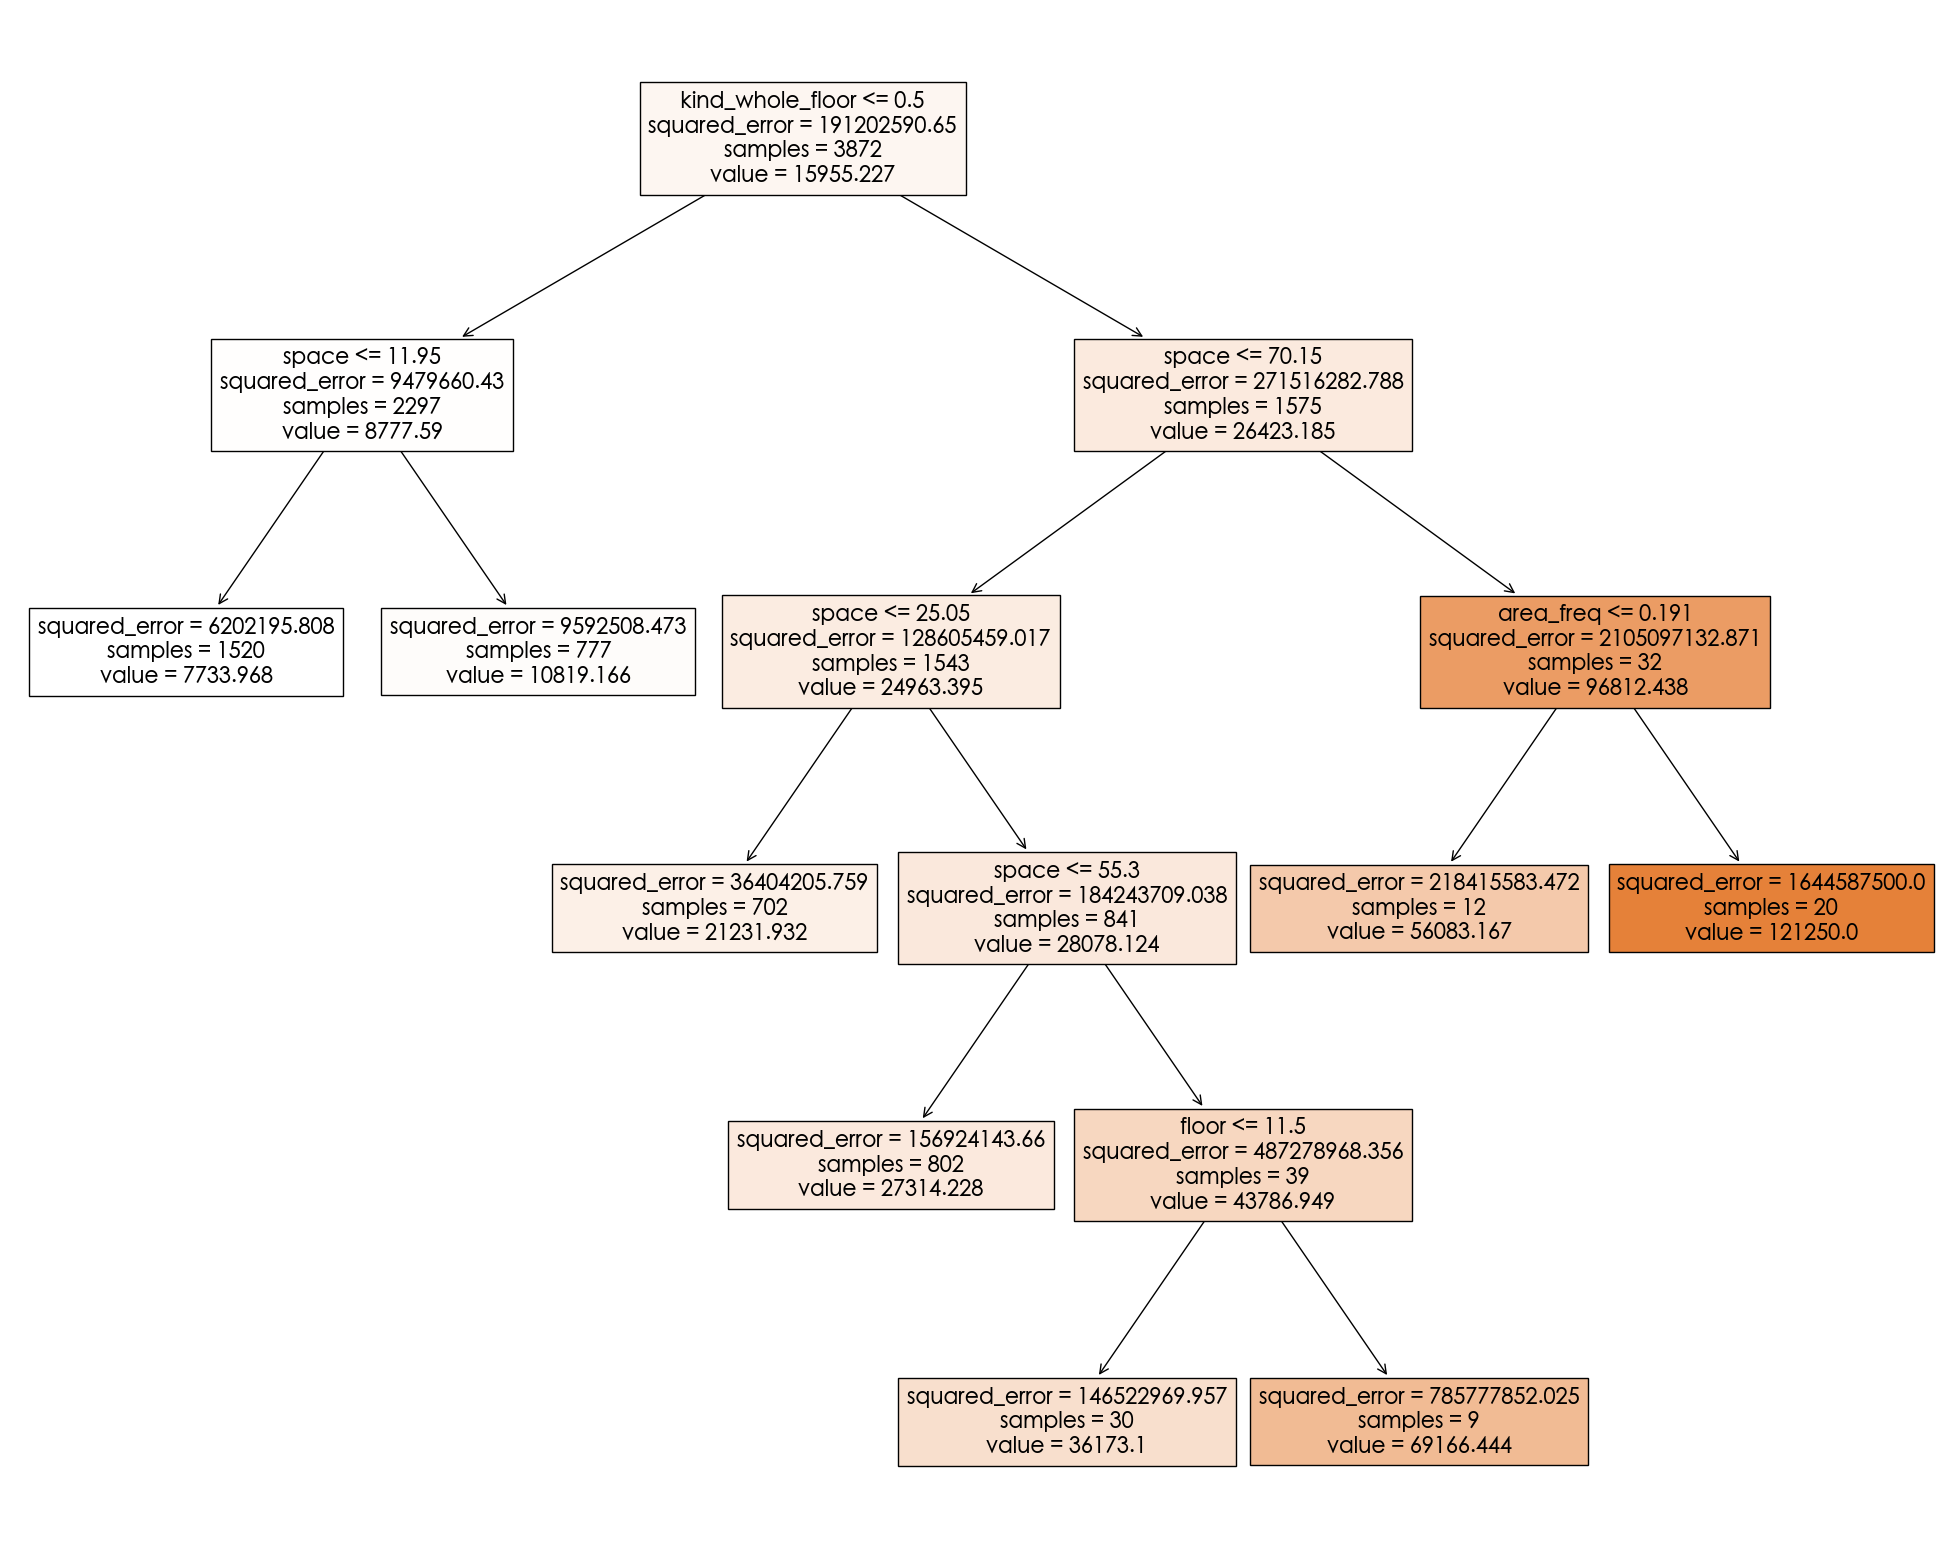

In [28]:
fig3 = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtr, 
                   feature_names=X.columns, 
                   filled=True)

整體來說我個人認為租屋市場在以MSE作為分枝的框架下所建立的樹模型並不好，主要原因是不夠的解釋力（分枝不夠多），這是由於我們是以training set 的MSE來分枝並以CV當中的test set的$R^2$選擇出的最佳alpha（最佳模型）而training set和test set的差異再加上$R^2$中SSE平方差的特性又會傾向於選到深度很淺的樹（為了讓test set的$R^2$較高）；其中價格租屋市場（非整層住家）的解釋力更是不足，原因在[25]我有以自身的觀察推理說明，因此我們可以考慮以MAE來作為分枝依據，並在CV時以MAE來選擇參數，讓training set test set的差距不會被$R^2$中的SSE平方差給放大，讓模型能留下更多的樹枝、有更多的預測值。

不過根據目前樹的模型可以發現一項有趣的現象，在坪數超過70.5的高級整層住家中，位於西屯區(area_freq大於0.191)的房租與非位於西屯區(area_freq小於0.191)的房租整整差了一倍以上，可見西屯區的高級住宅的特立獨行。

## Bulid decision tree (split with MAE)


本節將以MAE作為決策樹分枝的依據，改善以MSE分枝過少的問題，分別嘗試以網格搜索交叉驗證（GridCV）與CCP剪枝來構建模型。

### GridSearch CV to bulid tree

下方展示網格搜索交叉驗證來挑選最佳的模型，其中，是以'全樣本'在5 fold CV中以test set的平均MAE作為衡量標準，平均而言，最佳的模型參數是  
'max_depth'=7   
'min_samples_leaf'=5   
'min_samples_split'=10  
'splitter'='best'  

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
dtr = DecisionTreeRegressor(random_state = 100, criterion = 'absolute_error')
para = {"max_depth":[*range(2,16)]
        ,'splitter' :['random', 'best']
        , 'min_samples_split':[*range(10,210,50)]
        ,'min_samples_leaf':[*range(5,105,25)]
        }
GS = GridSearchCV(dtr, para, cv=5, scoring = "neg_mean_absolute_error", n_jobs = 4)

In [31]:
start = time.time()
GS.fit(X,y)
end = time.time()
print('The calculation cost: ',end - start, 'sec')

The calculation cost:  147.48975110054016 sec


In [32]:
GS.best_params_

{'max_depth': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'splitter': 'best'}

In [33]:
GS.best_estimator_

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=5, min_samples_split=10,
                      random_state=100)

### Visualize best model from GridSearch CV on test set

接著我們以GridCV中的最佳參數搭配training set建立一個以MAE分枝的樹模型。相比於MSE分枝、CV以$R^2$作為衡量標準，不僅模型增加了很多葉節點（預測值），且同時$R^2$還更好。不過，有個缺點是這個模型我個人認為過於複雜，也就是葉節點的數量太多了，解釋起來稍微太複雜了，若能在$R^2$與MAE不改變太多的情況下讓模型變簡單點那就再好不過了，因此，下小節我將考慮以CCP的方式來針對MAE分枝的樹剪枝。

In [34]:
dtr = GS.best_estimator_.fit(X_train, y_train)

In [35]:
pred_y_train = dtr.predict(X_train)
pred_y_test = dtr.predict(X_test)

In [36]:
from sklearn.metrics import mean_absolute_error
print('training set MAE :',mean_absolute_error(y_true = y_train, y_pred = pred_y_train))
print('test set MAE :', mean_absolute_error(y_true = y_test, y_pred = pred_y_test))

print('training R squared :', dtr.score(X_train, y_train))
print('test R squared :', dtr.score(X_test, y_test))

training set MAE : 2782.165547520661
test set MAE : 3377.02786377709
training R squared : 0.7525053275063132
test R squared : 0.7309523335269703


In [37]:
np.unique(pred_y_train)

array([  5000. ,   5399.5,   5500. ,   5749. ,   5799. ,   5900. ,
         6000. ,   6300. ,   6350. ,   6789. ,   6799.5,   6900. ,
         6999. ,   7100. ,   7499. ,   7500. ,   7999. ,   8000. ,
         8249. ,   8300. ,   8500. ,   8600. ,   8999. ,   9500. ,
         9999. ,  10000. ,  10999. ,  11000. ,  11500. ,  11749.5,
        11999.5,  12000. ,  12499. ,  12999. ,  13000. ,  13749. ,
        13999. ,  14100. ,  14999.5,  15000. ,  15250. ,  15800. ,
        17349. ,  17499. ,  17999. ,  18800. ,  20000. ,  20999.5,
        21999. ,  22000. ,  23000. ,  23999. ,  24000. ,  25000. ,
        25999.5,  26000. ,  27000. ,  27999. ,  30000. ,  34000. ,
        35500. ,  44999. ,  65000. ,  71500. ,  98000. , 120000. ,
       137000. ])

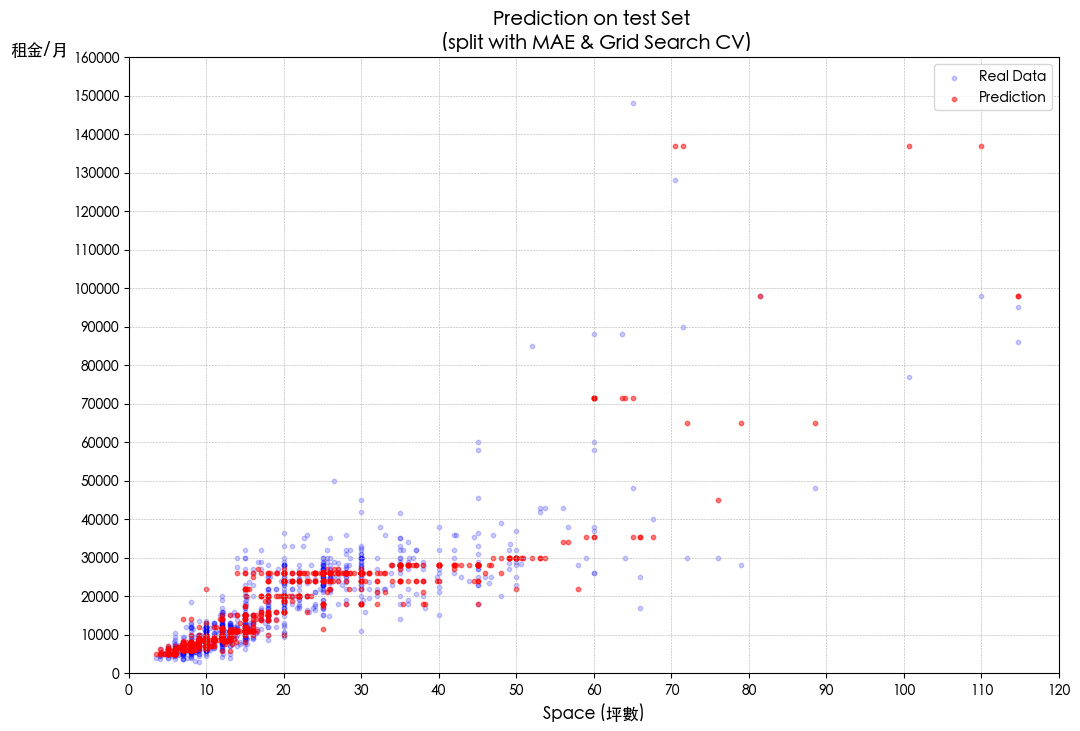

In [38]:
# test set (space and price)

plt.rcParams['font.family'] = ['Heiti TC']

fig2 = plt.figure(figsize=(12,8))

ax = fig2.add_subplot(111)
ax.scatter(X_test['space'], y_test, color = 'blue', s = 10, alpha = 0.2)  
ax.scatter(X_test['space'], pred_y_test, color = 'red', s = 10, alpha = 0.5)  
ax.set_ylim([0,160000])
ax.set_xlim([0, 120])
ax.set_yticks(np.linspace(0,160000,17))
ax.set_xticks(np.linspace(0,120,13))
ax.grid(linestyle='--', linewidth=0.4)

ax.set_xlabel("Space (坪數)",fontsize=12,rotation=0)
ax.set_ylabel("租金/月",fontsize=12, rotation=0, loc = 'top')
ax.set_title('Prediction on test Set \n (split with MAE & Grid Search CV)', fontsize=14)
ax.legend(['Real Data','Prediction'], fontsize = 10)

plt.show()

In [39]:
# text_representation = tree.export_text(GS.best_estimator_, feature_names = X.columns.tolist())
# print(text_representation)

In [40]:
import graphviz
from sklearn import tree

In [41]:
dot_data = tree.export_graphviz(GS.best_estimator_
                                ,feature_names= X_train.columns
                                ,filled=True
                                ,rounded=True
                                ,rotate = True
                                # , leaves_parallel = True
                                )


graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('tree_mae_GridCV',view=True)


'tree_mae_GridCV.png'

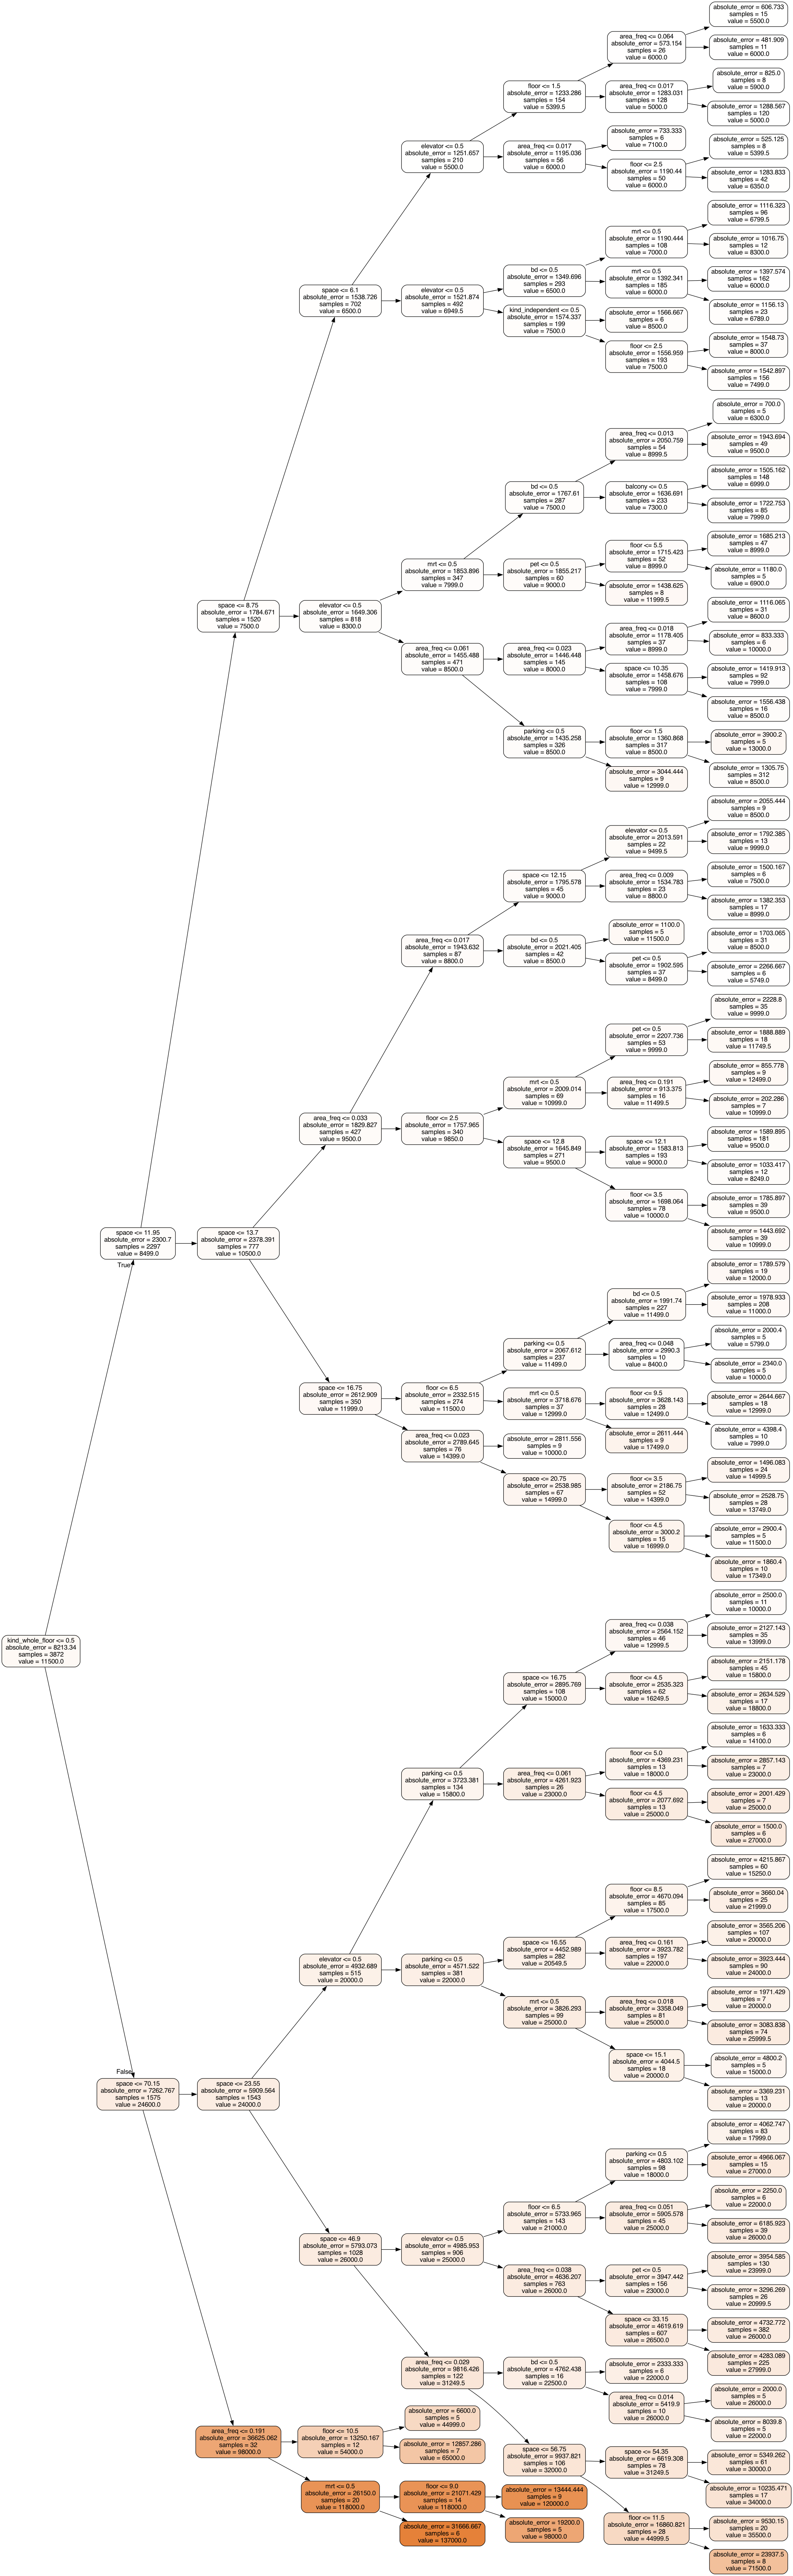

In [42]:
from IPython.display import Image
Image(filename=('./tree_mae_GridCV.png'),width=1500)



### Decision tree pruning with CCP (split with MAE)

首先，我們一樣先將MAE分枝的樹盡可能的生長，並蒐集每個剪枝階段的alpha與其對應的樹模型之MAE，我們希望能透過CV的方式找到平均而言最棒的那個alpha，具體做法是將蒐集到的所有alpha分別帶入以'全樣本'建模的5fold CV，並選擇在每次CV的test set下平均MAE最小的那個alpha作為最佳alpha。採用全樣本與5CV的原因是為更符合當前test set為全樣本20%的條件，讓每次CV的test set與當前要預測的test set較相近。

In [43]:
from sklearn.model_selection import cross_val_score
import time 

In [44]:
dtr = DecisionTreeRegressor(random_state = 100
                            , criterion = 'absolute_error'
                           ).fit(X_train, y_train)


model_prune = dtr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = model_prune['ccp_alphas']
impurities = model_prune['impurities']

pd.DataFrame(model_prune).T

0             1             2             3             4     \
ccp_alphas    0.00000 -4.440892e-16 -4.440892e-16 -4.440892e-16 -2.220446e-16   
impurities  383.01188  3.830119e+02  3.830119e+02  3.830119e+02  3.830119e+02   

                    5             6             7          8          9     \
ccp_alphas -1.110223e-16 -1.110223e-16 -1.110223e-16    0.00000    0.00000   
impurities  3.830119e+02  3.830119e+02  3.830119e+02  383.01188  383.01188   

            ...         1802         1803         1804         1805  \
ccp_alphas  ...    39.296488    41.293905    62.087293    73.187500   
impurities  ...  3294.163223  3335.457128  3397.544421  3470.731921   

                   1806         1807         1808         1809         1810  \
ccp_alphas    77.389463   126.549587   160.858471   186.982696   296.590393   
impurities  3548.121384  3674.670971  3835.529442  4022.512138  4319.102531   

                   1811  
ccp_alphas  3894.237345  
impurities  8213.339876  

[2 rows x 1812 columns]

In [45]:
ccp_alphas = ccp_alphas[ccp_alphas>=0]

In [46]:
len(ccp_alphas)

1805

In [47]:
np.unique(ccp_alphas).shape

(851,)

In [48]:
ccp_alphas = np.unique(ccp_alphas)

#### CV to choose best ccp_alpha (evaluate with negative MAE)

In [49]:
from sklearn.metrics import mean_absolute_error

In [50]:
ccp_train_maes = []
ccp_test_maes = []
start = time.time()

for i in ccp_alphas:
    
    dtr_prune = DecisionTreeRegressor(criterion='absolute_error'
                                      , ccp_alpha= i)
    
    ccp_test_mae = cross_val_score(dtr_prune, X, y, cv=5, scoring="neg_mean_absolute_error", n_jobs = 4).mean()
    ccp_test_mae = abs(ccp_test_mae)
    
    dtr_prune.fit(X_train,y_train)
    pred_y_train = dtr_prune.predict(X_train)
    
    ccp_train_mae = mean_absolute_error(y_train, pred_y_train)
    
    ccp_train_maes.append(ccp_train_mae)
    ccp_test_maes.append(ccp_test_mae)

end = time.time()
print('The calculation cost: ',end - start, 'sec')

The calculation cost:  955.7798199653625 sec


In [51]:
top_3_maes = sorted([* zip(ccp_alphas, ccp_test_maes, ccp_train_maes)], key=lambda a: a[1], reverse = False)[0:3]
top_3_maes

[(7.74793388429752, 3177.887224624517, 2789.373966942149),
 (6.164084022038569, 3179.055582456993, 2716.4411157024792),
 (6.973140495867767, 3193.877338399475, 2742.1126033057853)]

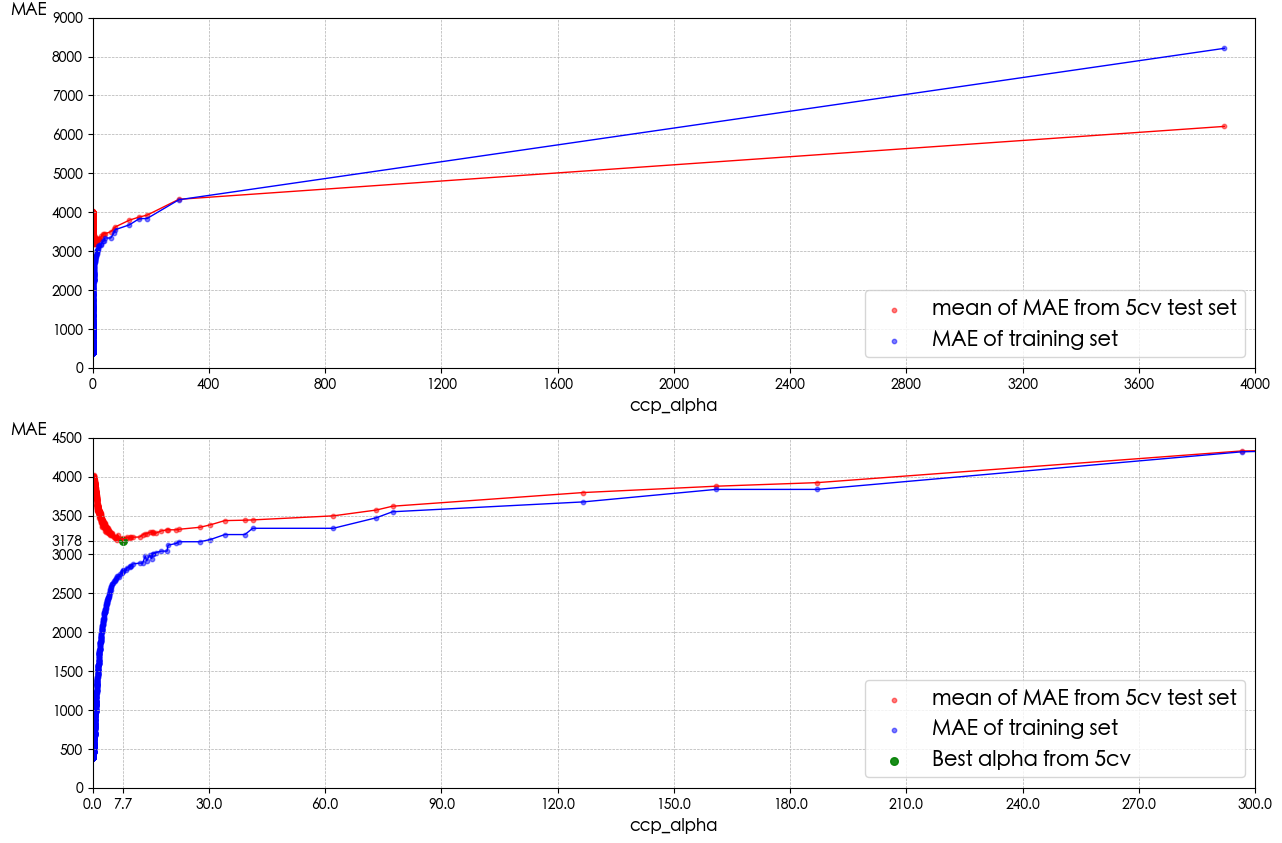

In [52]:
fig = plt.figure(figsize=(15,10))

sub1 = fig.add_subplot(211)
sub1.scatter(ccp_alphas, ccp_test_maes, color = 'red', s = 10, alpha = 0.5)  
sub1.scatter(ccp_alphas, ccp_train_maes, color = 'blue', s = 10, alpha = 0.5)  
sub1.plot(ccp_alphas, ccp_test_maes, color='red', linewidth=1)
sub1.plot(ccp_alphas, ccp_train_maes, color='blue', linewidth=1)
sub1.grid(linestyle='--', linewidth=0.5)
sub1.set_xlabel("ccp_alpha",fontsize=12,rotation=0)
sub1.set_ylabel("MAE",fontsize=12, rotation=0, loc = 'top')
sub1.set_ylim([0,9000])
sub1.set_xlim([0, 4000])
sub1.set_xticks(np.linspace(0,4000,11))
sub1.set_yticks(np.linspace(0,9000,10))
sub1.legend(['mean of MAE from 5cv test set', 'MAE of training set'], fontsize = 15, loc = "lower right")


sub2 = fig.add_subplot(212)
sub2.scatter(ccp_alphas, ccp_test_maes, color = 'red', s = 10, alpha = 0.5)  
sub2.scatter(ccp_alphas, ccp_train_maes, color = 'blue', s = 10, alpha = 0.5)  

sub2.scatter(top_3_maes[0][0], top_3_maes[0][1], color = 'green', s = 30, alpha = 0.9) 
sub2.plot(ccp_alphas, ccp_test_maes, color='red', linewidth=1)
sub2.plot(ccp_alphas, ccp_train_maes, color='blue', linewidth=1)
sub2.grid(linestyle='--', linewidth=0.5)
sub2.set_xlabel("ccp_alpha",fontsize=12,rotation=0)
sub2.set_ylabel("MAE",fontsize=12, rotation=0, loc = 'top')
sub2.set_ylim([0,4500])
sub2.set_xlim([0,300])
sub2.set_xticks(np.append(np.linspace(0,300,11),top_3_maes[0][0]))
sub2.set_yticks(np.append(np.linspace(0,4500,10),top_3_maes[0][1]))
sub2.legend(['mean of MAE from 5cv test set', 'MAE of training set', 'Best alpha from 5cv'], fontsize = 15
            ,loc = "lower right")
plt.show()

### Visualize pruned tree from CCP

根據結果得到平均而言，alpha = 7.74793388429752，在CV test set的表現最佳（MAE最小），我們將以最佳alpha在原本的training set上建模，並加上葉節點的樣本數要大於等於5的條件，最後用該模型來預測test set。可以由[53]、[54]、[59]發現此時的模型在犧牲些微的$R^2$與MAE的同時，大大的減少了模型的葉節點，簡化了原本分枝複雜的模型。

In [53]:
dtr = DecisionTreeRegressor(random_state = 100
                            , criterion = 'absolute_error'
                            , min_samples_leaf = 5
                            , ccp_alpha = top_3_maes[0][0]).fit(X_train, y_train)

pred_y_train = dtr.predict(X_train)
pred_y_test = dtr.predict(X_test)

print('training R squared :', dtr.score(X_train, y_train))
print('training MAE :', mean_absolute_error(y_train, pred_y_train))
print('test R squared :', dtr.score(X_test, y_test))
print('test MAE :', mean_absolute_error(y_test, pred_y_test))



training R squared : 0.7483922398835638
training MAE : 2917.7319214876034
test R squared : 0.7312766405985075
test MAE : 3410.081527347781


In [54]:
np.unique(pred_y_train)

array([  5500. ,   6500. ,   7500. ,   8300. ,   9500. ,  11500. ,
        12999.5,  14399. ,  15250. ,  16249.5,  17999. ,  20000. ,
        21999. ,  22500. ,  23000. ,  24000. ,  25000. ,  27000. ,
        27999. ,  31249.5,  35500. ,  44999. ,  65000. ,  71500. ,
        98000. , 120000. , 137000. ])

In [55]:
np.unique(pred_y_test)

array([  5500. ,   6500. ,   7500. ,   8300. ,   9500. ,  11500. ,
        12999.5,  14399. ,  15250. ,  16249.5,  17999. ,  20000. ,
        21999. ,  22500. ,  23000. ,  24000. ,  25000. ,  27000. ,
        27999. ,  31249.5,  35500. ,  44999. ,  65000. ,  71500. ,
        98000. , 120000. , 137000. ])

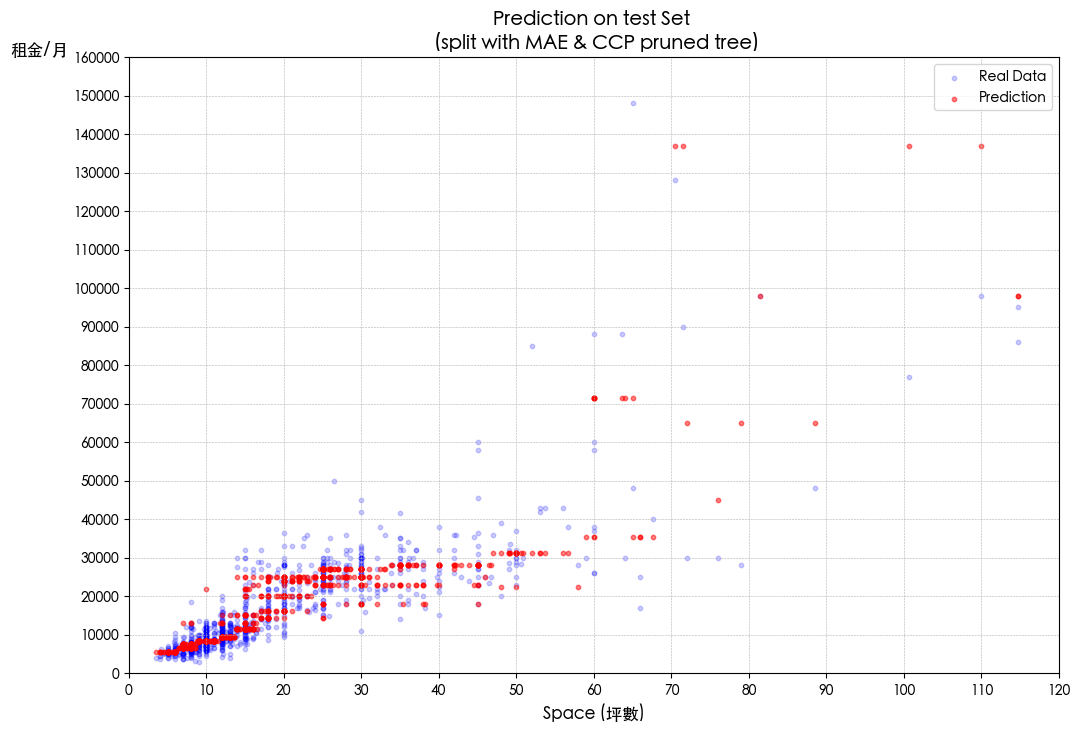

In [56]:
# test set (space and price)

plt.rcParams['font.family'] = ['Heiti TC']

fig2 = plt.figure(figsize=(12,8))

ax = fig2.add_subplot(111)
ax.scatter(X_test['space'], y_test, color = 'blue', s = 10, alpha = 0.2)  
ax.scatter(X_test['space'], pred_y_test, color = 'red', s = 10, alpha = 0.5)  

ax.set_ylim([0,160000])
ax.set_xlim([0, 120])
ax.set_yticks(np.linspace(0,160000,17))
ax.set_xticks(np.linspace(0,120,13))
ax.grid(linestyle='--', linewidth=0.4)

ax.set_xlabel("Space (坪數)",fontsize=12,rotation=0)
ax.set_ylabel("租金/月",fontsize=12, rotation=0, loc = 'top')
ax.set_title('Prediction on test Set \n (split with MAE & CCP pruned tree)', fontsize=14)
ax.legend(['Real Data', 'Prediction'], fontsize = 10)

plt.show()



In [57]:
import graphviz
from sklearn import tree

In [58]:
dot_data = tree.export_graphviz(dtr
                                ,feature_names= X_train.columns
                                ,filled=True
                                ,rounded=True
                                ,rotate = True
                                # , leaves_parallel = True
                                )


graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('tree_mae_ccp',view=True)

'tree_mae_ccp.png'

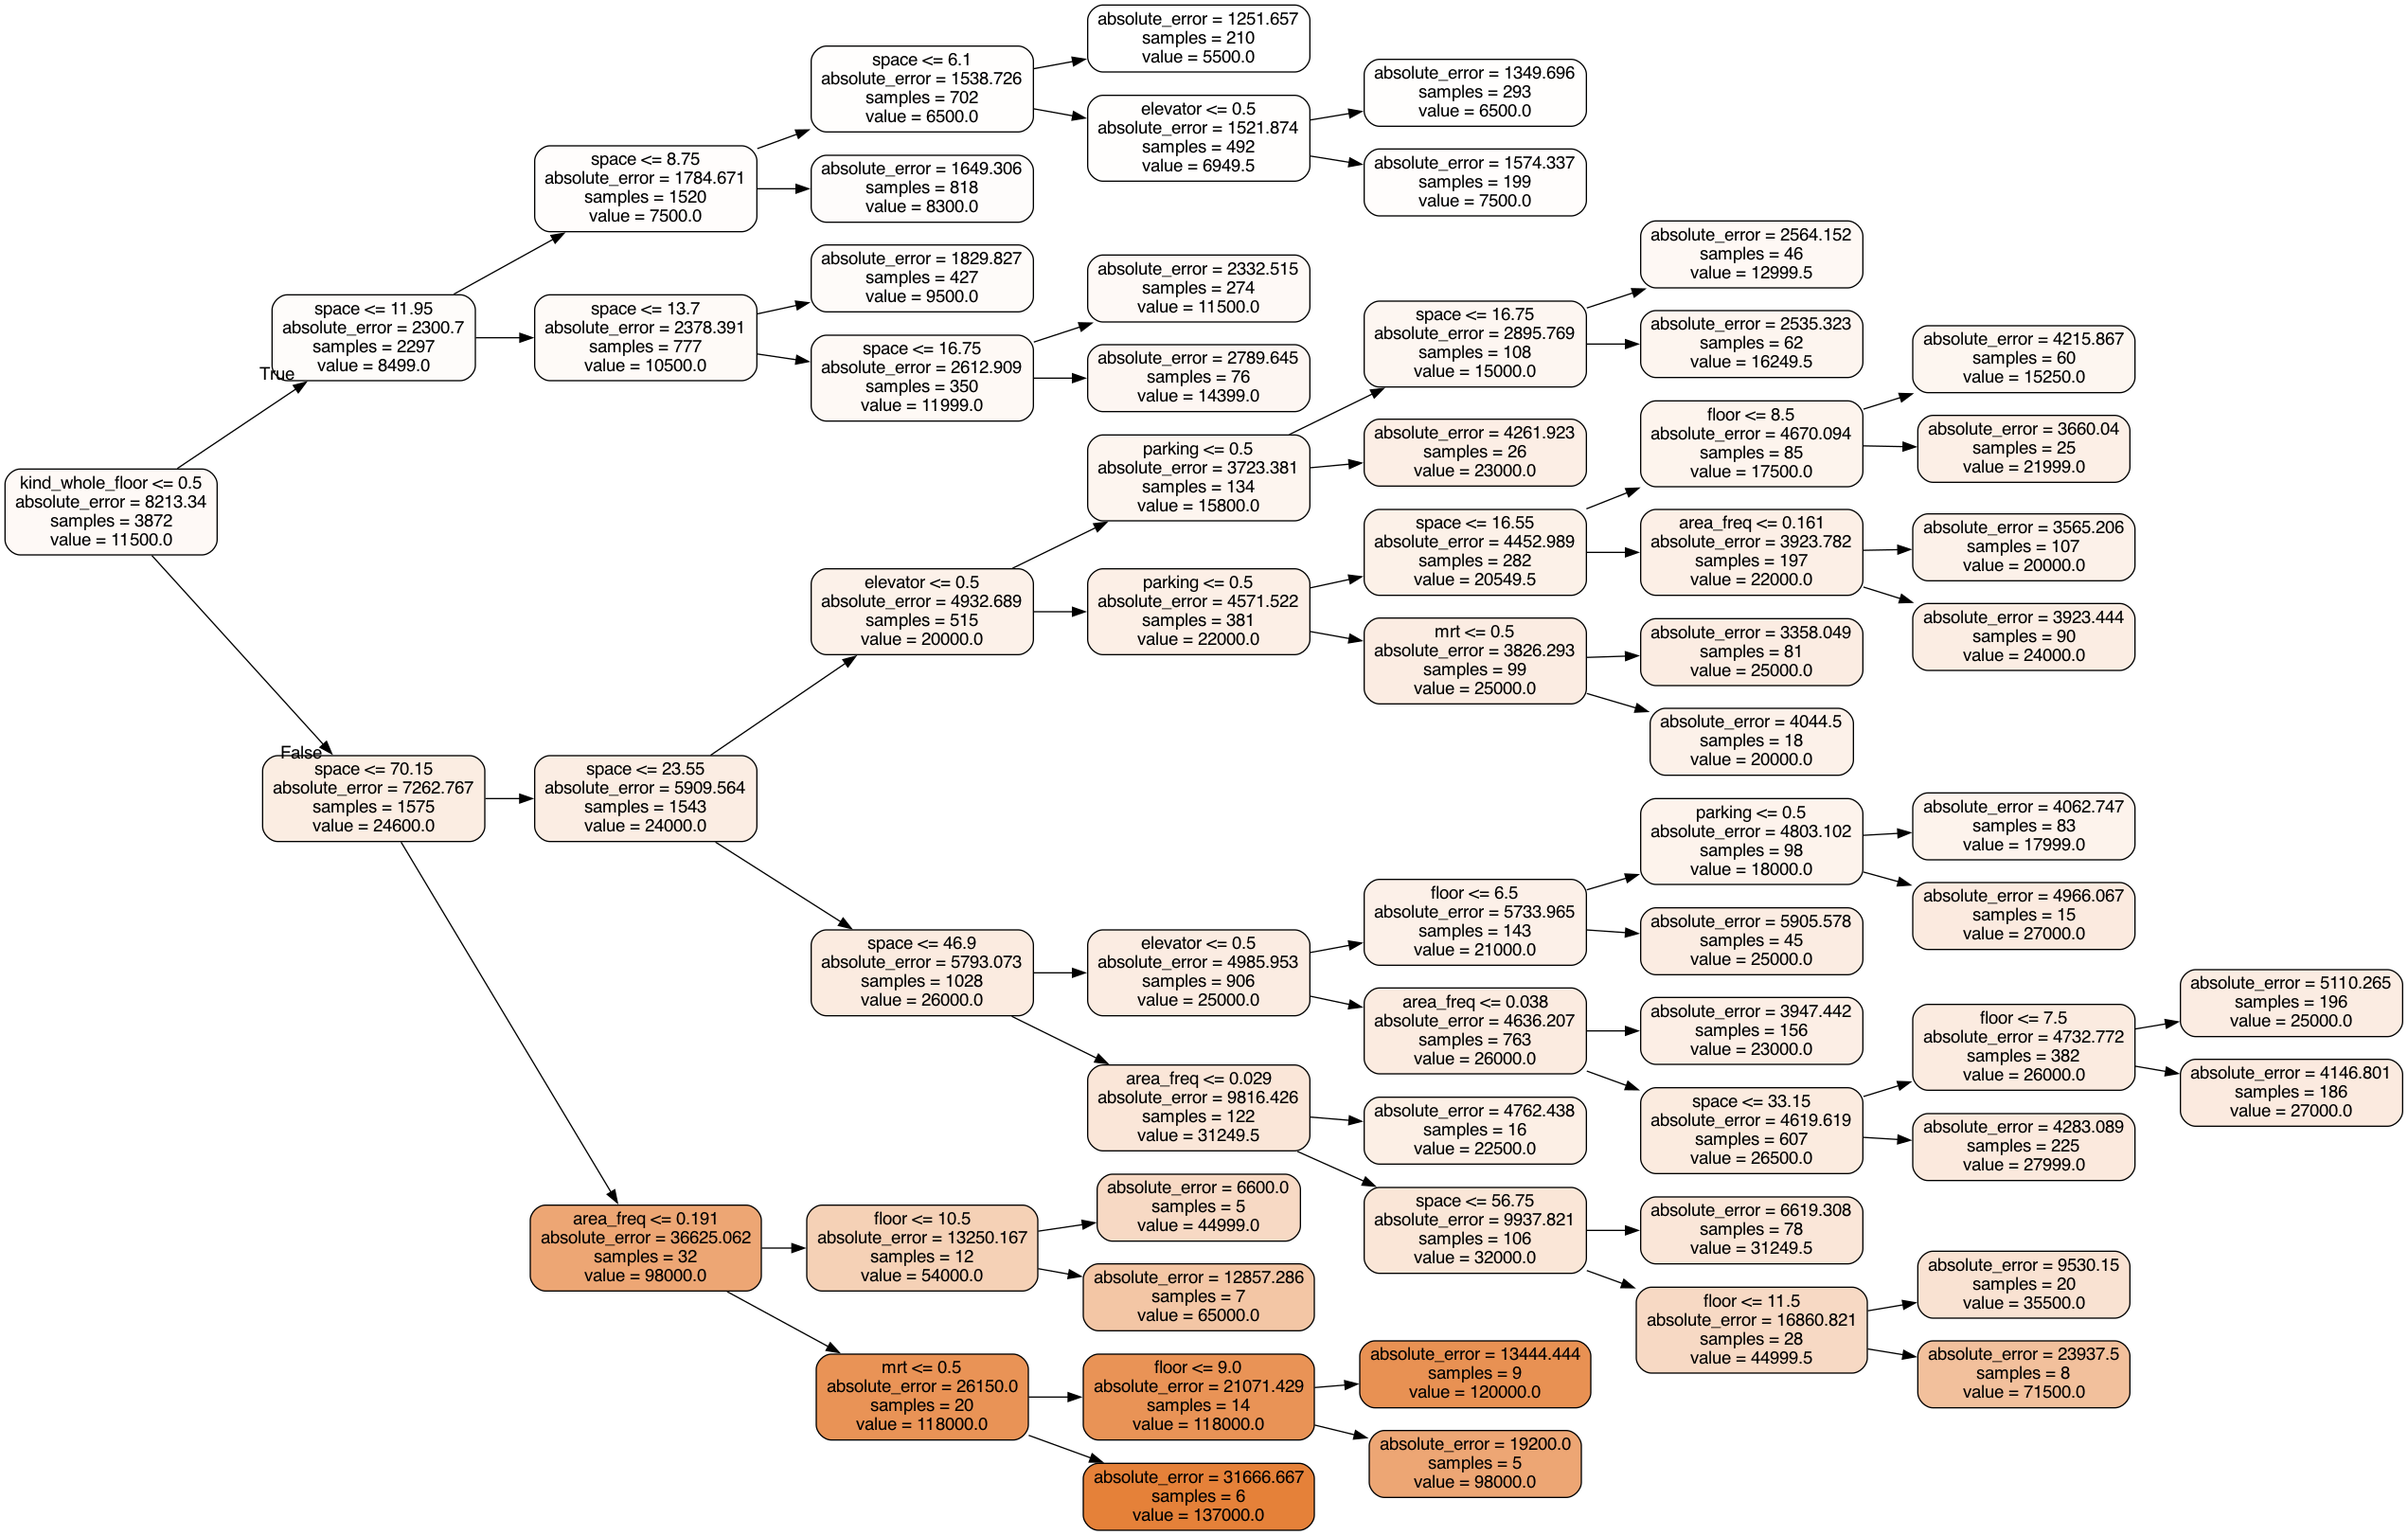

In [59]:
from IPython.display import Image
Image(filename=('./tree_mae_ccp.png'),width=1500)

# Random Forest Regression

下方將嘗試以隨機森林迴歸來建模，以150棵樹的平均結果來當做預測值，每棵樹的分枝仍然是以MAE來分枝，而參數的選擇以GridCV來選擇，其中不同於先前，在此5 fold CV中衡量的標準是採用以$R^2$來衡量（我認為既然輸出是150顆樹的平均，此時應以整體的解釋能力$R^2$來作為衡量標準可能較適合）。

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import time

In [61]:
rfr = RandomForestRegressor(random_state = 100
                            , criterion = 'absolute_error'
                            , bootstrap = True
                            , oob_score = True
                            , n_estimators = 150)

para = {"max_depth":[*range(3,16)]
        , 'min_samples_leaf':[*range(5,55,10)]
        }

GS = GridSearchCV(rfr, para, cv=5, scoring = 'r2', n_jobs = 4)
start = time.time()
GS.fit(X,y)
end = time.time()
print('The calculation cost: ',end - start, 'sec')

The calculation cost:  1858.8609399795532 sec


In [62]:
GS.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_depth=13,
                      min_samples_leaf=5, n_estimators=150, oob_score=True,
                      random_state=100)

In [63]:
rfr = GS.best_estimator_.fit(X_train,y_train)

In [64]:
pred_y_train = rfr.predict(X_train)
pred_y_test = rfr.predict(X_test)

In [65]:
from sklearn.metrics import mean_absolute_error
print('training set MAE :',mean_absolute_error(y_true = y_train, y_pred = pred_y_train))
print('test set MAE :', mean_absolute_error(y_true = y_test, y_pred = pred_y_test))

print('training R squared :', rfr.score(X_train, y_train))
print('test R squared :', rfr.score(X_test, y_test))

training set MAE : 2444.346703684573
test set MAE : 3216.17077743378
training R squared : 0.7658624327366677
test R squared : 0.7622963582003512


In [66]:
rfr.oob_score_

0.7181644781477141

註：在boostrap抽樣方式下，每顆樹大約有32%的樣本作為測試集，整座森林平均而言也以近似32%的樣本作為test set(OOB set)，所以此時的$R^2$當然會比20%test set還低。

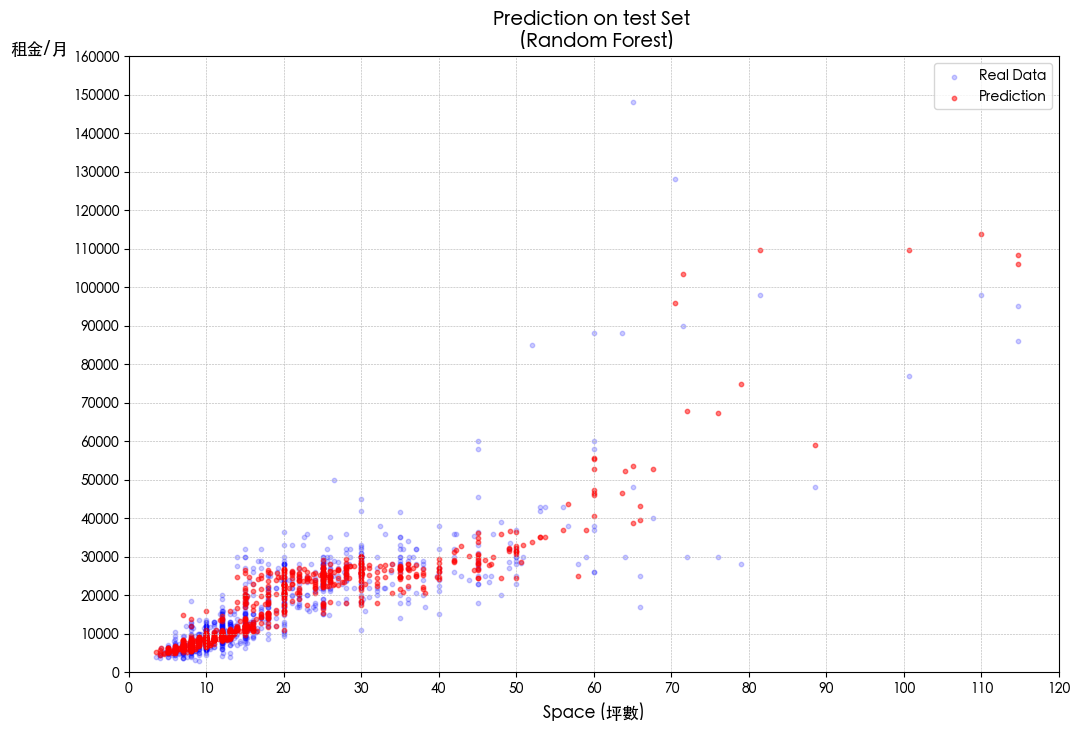

In [67]:
plt.rcParams['font.family'] = ['Heiti TC']

fig2 = plt.figure(figsize=(12,8))

ax = fig2.add_subplot(111)
ax.scatter(X_test['space'], y_test, color = 'blue', s = 10, alpha = 0.2)  
ax.scatter(X_test['space'], pred_y_test, color = 'red', s = 10, alpha = 0.5)  

ax.set_ylim([0,160000])
ax.set_xlim([0, 120])
ax.set_yticks(np.linspace(0,160000,17))
ax.set_xticks(np.linspace(0,120,13))
ax.grid(linestyle='--', linewidth=0.4)

ax.set_xlabel("Space (坪數)",fontsize=12,rotation=0)
ax.set_ylabel("租金/月",fontsize=12, rotation=0, loc = 'top')
ax.set_title('Prediction on test Set \n (Random Forest)', fontsize=14)
ax.legend(['Real Data', 'Prediction'], fontsize = 10)

plt.show()


# Conclusion

總結，比較三個樹模型與一座隨機森林的結果，直觀上我們可以以'預測表現'與'便於解釋的程度'來評比。  
首先，在'預測表現'中以$R^2$與MAE來比較得到：  
Random Forest(GridCV)＞Tree(GridCV & split with MAE)＞Tree(CCP & split with MAE)＞Tree(CCP & split with MSE)，單純以數值準確度層面來選擇模型的話，首選為隨機森林，其達到了76%的解釋力。  
在'便於解釋的程度'方面：  
Tree(CCP & split with MSE)＞Tree(CCP & split with MAE)＞Tree(GridCV & split with MAE)＞Random Forest(GridCV)，尤其後兩者的結構十分複雜，因此同時考量便於解釋的程度與預測表現，我個人傾向於選擇Tree(CCP & split with MAE)，根據[59]其大致上將租屋類型分為四大塊:  
1. 非整層住家（內部主要又以坪數細分）  
2. 整層住家坪數小於23.55坪（電梯與停車位在此類當中較重要）
3. 整層住家坪數大於23.55坪且小於70.15坪（坪數、電梯、行政區在此類較重要）
4. 整層住家坪數大於70.15坪（行政區是否是西屯區在此類最重要）

<!-- 
training set MAE : 3541.1085988204945<p>
test set MAE : 3904.503231491259<p>
training R squared : 0.7092267108225283<p>
test R squared : 0.7184548477363382<p>
<p>
<p>
<p>
training set MAE : 2584.8535640495866<p>
test set MAE : 3438.018575851393<p>
training R squared : 0.7577799465767896<p>
test R squared : 0.7375236486004655<p>
<p>
<p>
<p>    
training R squared : 0.7488970895300917<p>
training MAE : 2909.9845041322315<p>
test R squared : 0.7322191700969253<p>
test MAE : 3388.8261093911246<p>
<p>
<p>
<p>
training set MAE : 2444.346703684573<p>
test set MAE : 3216.17077743378<p>
training R squared : 0.7658624327366677<p>
test R squared : 0.7622963582003512<p> -->

In [70]:
x = np.arange(1,5)
info = {'training set MAE':[3541.1085988204945, 2782.165547520661, 2909.9845041322315, 2444.346703684573],
        'test set MAE':[3904.503231491259, 3377.02786377709, 3388.8261093911246, 3216.17077743378],
        'training set R squared':[0.7092267108225283, 0.7525053275063132, 0.7488970895300917, 0.7658624327366677],
        'test set R squared':[0.7184548477363382, 0.7309523335269703, 0.7322191700969253, 0.7622963582003512]
       }
             
info['training set MAE']

[3541.1085988204945, 2782.165547520661, 2909.9845041322315, 2444.346703684573]

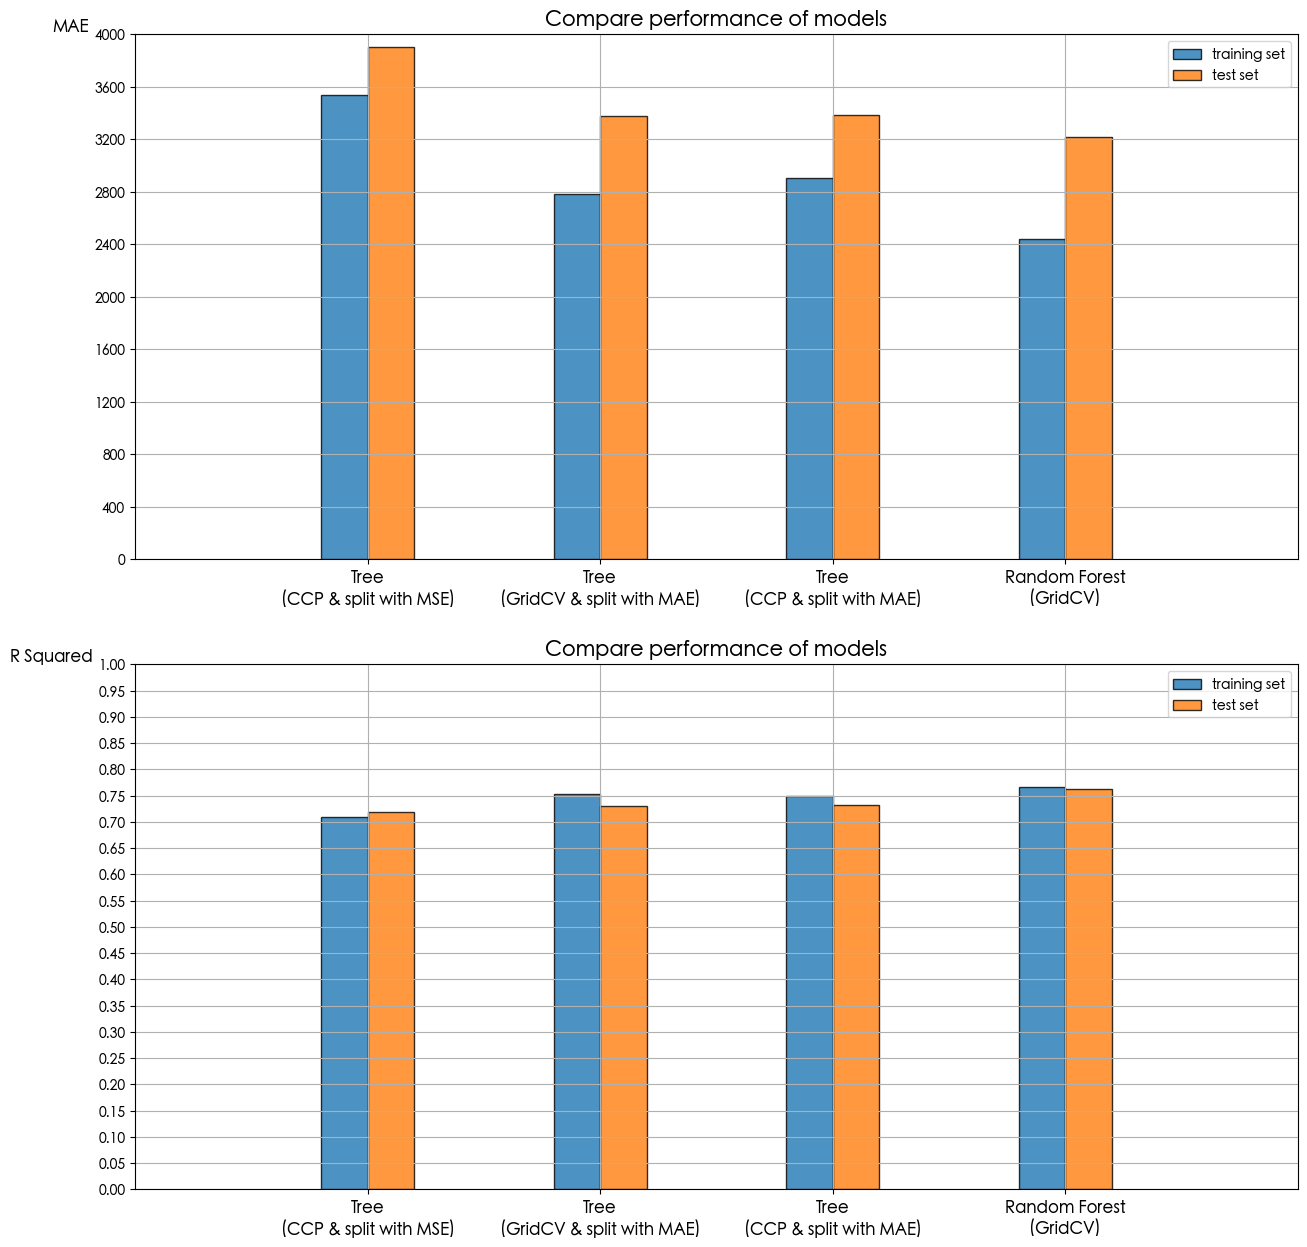

In [71]:
fig = plt.figure(figsize=(15,15))
xlabels = ['Tree\n(CCP & split with MSE)',
           'Tree\n(GridCV & split with MAE)',
           'Tree\n(CCP & split with MAE)',
           'Random Forest\n(GridCV)']

sub1 = fig.add_subplot(211)
sub1.bar(x = x-0.1, height = info['training set MAE'], width = 0.2, alpha = 0.8, edgecolor = 'k')
sub1.bar(x = x+0.1, height = info['test set MAE'], width = 0.2, alpha = 0.8, edgecolor = 'k')  
sub1.grid()
sub1.set_xlim([0,5])
sub1.set_ylim([0, 4000])
sub1.set_xticks(np.linspace(1,4,4))
sub1.set_yticks(np.linspace(0,4000,11))
sub1.set_xticklabels(xlabels ,fontsize=12,rotation=0)
sub1.set_ylabel("MAE",fontsize=12,rotation=0, loc = 'top')
sub1.legend(['training set','test set'])
sub1.set_title('Compare performance of models', fontsize = 15)

sub2 = fig.add_subplot(212)
sub2.bar(x = x-0.1, height = info['training set R squared'], width = 0.2, alpha = 0.8, edgecolor = 'k')
sub2.bar(x = x+0.1, height = info['test set R squared'], width = 0.2, alpha = 0.8, edgecolor = 'k')  
sub2.grid()
sub2.set_xlim([0,5])
sub2.set_ylim([0, 1])
sub2.set_xticks(np.linspace(1,4,4))
sub2.set_yticks(np.linspace(0,1,21))
sub2.set_xticklabels(xlabels ,fontsize=12,rotation=0)
sub2.set_ylabel("R Squared",fontsize=12,rotation=0, loc = 'top')
sub2.legend(['training set','test set'])
sub2.set_title('Compare performance of models', fontsize = 15)


plt.show()